In [8]:
import mido
import numpy as np
import matplotlib.pyplot as plt 
import string 
import dissonant as D
import pretty_midi
import os
import json
import ntpath
import shutil
from numpy.lib.histograms import histogram

def msg2dict(msg): # a costume function with a messege variable in it
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    #conditions for when note is on/off, if it is then on_ = true and if it isnt then on_ = false

    result['time'] = int(msg[msg.rfind('time'):]
    # time in the result array equals to an integer of the messege's last mentioned 'time' value
    .split(' ')[0].split('=')[1]
    # then 
    .translate(str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None: # if on_ is equal to false/true
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):]
            .split(' ')[0].split('=')[1]
            .translate(str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

'''
The function msg2dict extracts important informationP
(note, velocity, time, on or off) from each message.
'''

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

'''
The function switch_note changes the last_state 
(the state of the 88 note at the previous time step)
based on new value of note, veloc    print(result)n or note off.
The state of each time step contains 88 values.
'''

def get_new_state(new_msg, last_state):
    #print(new_msg)
    new_dict, on_ = msg2dict(str(new_msg))
    # print(new_dict)
    new_state = switch_note(last_state, note=new_dict['note'], velocity=new_dict['velocity'], on_=on_) if on_ is not None else last_state
    #print(len(new_state))
    # print(new_state)
    return [new_state, new_dict['time']]


'''
The function track2seq takes the threshold of minimum number of messages into consideration while filtering tracks,
and combines all tracks into one numpy array.
If two sound track on the same note at the same time, it takes the larger velocity.
'''

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    jump = []
    msg = str(track[0])
    last_state, last_time = get_new_state(msg, [0]*88)
    for i in range(1, len(track)):
        msg = str(track[i])
        #check if state dosnt change and there is still a message ???????? 
        new_state, new_time = get_new_state(msg, last_state)
        if new_time > 0:
            # print(new_time)
            result += [last_state]*new_time
            jump.append(len(result))
        last_state, last_time = new_state, new_time
        #debug = str(last_state) + ":"+ str(last_time) 
    return jump , result

'''
The function track2seq converts each message in a track to a list of 88 values,
and stores each list in the result list in order.
'''

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    all_jumps = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            # print("==========================================")
            # print(mid.tracks[i])
            jump_i , ary_i = track2seq(mid.tracks[i])
            # print("+++++++++++++++++++++++++++++++++++++++++++++++++")
            # print("==========================================")
            all_arys.append(ary_i)
            all_jumps.append(jump_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys  = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    all_jumps = np.array(all_jumps)
    if len(all_arys) > 2: 
        return all_arys[min(ends): max(ends)],all_jumps
    else:
        return all_arys,all_jumps
#a new fuction that gets the changes of the notes in specific times
def get_dissonance(result_array,jump_array): 
    dictinary_array = []
    start_time  = 0
    for element in jump_array[0]:
        len_result_array = result_array.shape[0]
        if element < len_result_array: 
            res = result_array[element]
            notes = [i+21 for i, e in enumerate(res) if e != 0]
            velocity = [float(e) for e in res if e != 0]
            hertz = []  
            name = []  
            for note in notes:
                hertz.append(pretty_midi.note_number_to_hz(note))
                name.append(pretty_midi.note_number_to_name(note))
            
            if len(notes) > 1: 
                dissonance = D.dissonance(np.array(hertz),np.array(velocity), model='sethares1993')
            else:
                dissonance = 0
            
            end_time = element   
            dictionary = dict({'time': end_time - start_time, 'name': name, 'notes': notes, 'velocity': velocity, 'hertz': hertz, 'dissonance': dissonance}) # i read that velocity = amplitude
            start_time = end_time
            
            dictinary_array.append(dictionary)
    
    return dictinary_array 

            
def msg_disonance(mid): 
    result_array,jump_array = mid2arry(mid)
    res = get_dissonance(result_array,jump_array)
    # print(res)
    dissonance_array = []
    time_array = []
    total_time = 0
    for element in res:
        dissonance = element.get('dissonance')
        dissonance_array.append(dissonance)
        time = element.get('time')
        time_array.append(time)
        total_time = total_time + time  
        
    
    return time_array,dissonance_array

def avrage_dissonance(mid): 
    time_array,dissonance_array = msg_disonance(mid) 
    if sum(time_array)==0:
        return  0 
    return np.dot(time_array,dissonance_array)/sum(time_array)

def save_dissonance_file(folder_path,output_file): 
    
    dir_list = os.listdir(folder_path)

    avg_dissonance_dictionary = []

    for file in dir_list:
       mid = mido.MidiFile(f'{folder_path}/{file}', clip=True)
       dissonance = avrage_dissonance(mid)
       avg_dissonance_dictionary.append(dict({'file': f'{folder_path}/{file}', 'dissonance': dissonance}))

    avg_dissonance_dictionary = sorted(avg_dissonance_dictionary, reverse= True, key= lambda k: k['dissonance'])

    with open(output_file, 'w') as fp:
        json.dump(avg_dissonance_dictionary, fp)

def get_dissonance_folder_avg(folder_path): 

    dir_list = os.listdir(folder_path)

    avg_dissonance_array = []
    
    for file in dir_list:
       mid = mido.MidiFile(f'{folder_path}/{file}', clip=True)
       dissonance = avrage_dissonance(mid)
       avg_dissonance_array.append(dissonance)

    avg_dissonance = sum(avg_dissonance_array) / len(avg_dissonance_array)
    return avg_dissonance

def get_avg_dissonances_in_folder_array(folder_path): 

    dir_list = os.listdir(folder_path)

    avg_dissonance_array = []
    
    for file in dir_list:
       mid = mido.MidiFile(f'{folder_path}/{file}', clip=True)
       dissonance = avrage_dissonance(mid)
       avg_dissonance_array.append(dissonance)

    return avg_dissonance_array

def dissonance_histogram_data(folder_path):

    midi_files_avg_disonance_array = get_avg_dissonances_in_folder_array(folder_path)

    plt.hist(midi_files_avg_disonance_array, len(midi_files_avg_disonance_array), facecolor='blue', alpha=0.7)
    plt.xlabel('Dissonance Value')
    plt.ylabel('Num of files')
    plt.title('Histogram of the dissonance value')
    plt.rcParams['figure.figsize'] = [10, 4]
    plt.fill_betweenx(x1= 0, x2= 300)
    plt.legend()
    plt.show()
    plt.savefig(f'Histogram.png')

def dissonance_histogram_folders(folder_path1, folder_path2):

    midi_files_avg_disonance_array1 = get_avg_dissonances_in_folder_array(folder_path1)
    midi_files_avg_disonance_array2 = get_avg_dissonances_in_folder_array(folder_path2)

    plt.hist(midi_files_avg_disonance_array1, len(midi_files_avg_disonance_array1), facecolor='blue', alpha=0.7, label='Normal data')
    plt.xlabel('Dissonance Value')
    plt.ylabel('Num of files')
    plt.title('Histogram of the dissonance value in both datas')
    plt.hist(midi_files_avg_disonance_array2, len(midi_files_avg_disonance_array2), facecolor='red', alpha=0.7, label='Data under 300 dissonance value')
    plt.rcParams['figure.figsize'] = [15, 4]
    plt.legend()
    plt.show()
    plt.savefig(f'Histogram.png')


folder_data = "/home/beer/yuval/data/midi/classic_piano"
folder_filtered_data = "/home/beer/yuval/data/midi/classic_piano_300"
folder_path_normal = "/home/beer/yuval/Generate_output/"
folder_path_dissonance_300 = "/home/beer/yuval/Generate_output_dissonance_300/"

dissonance_histogram_data(folder_data)

dissonance_file = "dissonance.json" 

# save_dissonance_file(folder_path_dissonance_300, f'dissonance_300.json')




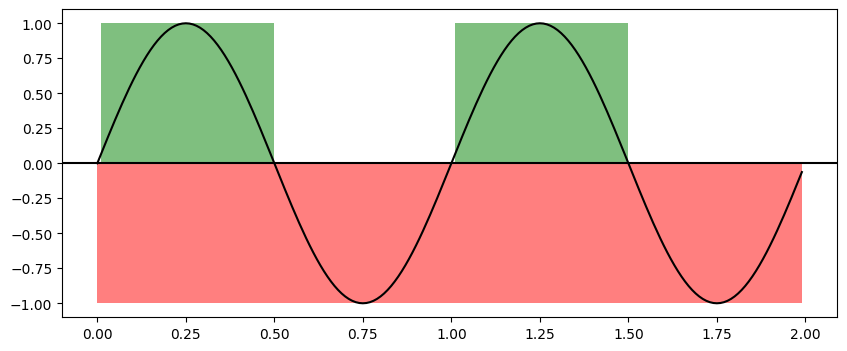

In [6]:
import numpy as np
import matplotlib.pyplot as plt


t = np.arange(0.0, 2, 0.01)
s = np.sin(2*np.pi*t)

fig, ax = plt.subplots()

ax.plot(t, s, color='black')
ax.axhline(0, color='black')

ax.fill_between(t, 1, where=s > 0, facecolor='green', alpha=.5)
ax.fill_between(t, -1, facecolor='red', alpha=.5)

plt.show()
